## Data Preparation

The raw expression data can be download from https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/fresh_68k_pbmc_donor_a. Then preprocess the raw expression data into h5ad format and saved as 68kPBMCs.h5ad.
The annoatation can be download from https://github.com/10XGenomics/single-cell-3prime-paper and saved as 68k_pbmc_barcodes_annotation.tsv

Next, we filter genes based on number of cells and select highly variable genes. After that, we renormalize the gene expression due to cscGAN/scGAN use nromalized expression as input.

Then, following scGAN, we use Louvain algorithm to cluster scRNA-seq data.  

We also provide demo data as shown in ../demo_data/simulation/input and expected output as shown in ../demo_data/simulation/output 

In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
data = sc.read_h5ad('../../scGRN/scGAN-master/68kPBMCs.h5ad')
annotation = pd.read_csv('../../scGRN/PBMC/68k_pbmc_barcodes_annotation.tsv',sep='\t')
annotation_dict = {item['barcodes']:item['celltype'] for item in annotation.to_dict('records')}
data.obs['barcodes'] = data.obs.index
data.obs['celltype'] = data.obs['barcodes'].map(annotation_dict)

sc.pp.filter_genes(data,min_cells=686)
sc.pp.filter_cells(data,min_genes=10)
sc.pp.normalize_per_cell(data,20000)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data,n_top_genes=1000)
data.X = np.exp(data.X.toarray())-1
data=data[:,data.var['highly_variable']]
sc.pp.normalize_per_cell(data,3800)

clustered = sc.read_h5ad('../../scGRN/scGAN-master/68kPBMCs.h5ad')
sc.pp.recipe_zheng17(clustered)
sc.tl.pca(clustered, n_comps=50)
sc.pp.neighbors(clustered, n_pcs=50)
sc.tl.louvain(clustered, resolution=0.15)
clustered.obs.groupby('louvain').count()
data.obs['louvain'] = list(clustered.obs['louvain'])
split = pd.DataFrame(data.obs['barcodes'])
test = split.sample(frac=0.2)
d_split = {item:'test' for item in test['barcodes']}
data.obs['split'] = data.obs['barcodes'].map(d_split).fillna('train')
data.write_h5ad('./68k_pbmc_data_1000_high_variable.h5ad')

Trying to set attribute `.obs` of view, copying.


         Falling back to preprocessing with `sc.pp.pca` and default params.


/sda4/shuhantao/anaconda2/envs/geometric/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)
... storing 'celltype' as categorical
... storing 'louvain' as categorical
... storing 'split' as categorical


## Run DeepSEM on preprocessed data

Run DeepSEM by using command "python main.py --data_file ../demo_data/simulation/input/PBMC_CD19+B.csv --task simulation "

In [ ]:
! nohup python main.py --data_file ../demo_data/simulation/input/PBMC_CD19+B.csv --task simulation  &

In [189]:
import numpy as np
adata = sc.read_h5ad('../../scGRN/PBMC//68k_pbmc_data_1000_high_variable.h5ad')
train = adata[adata.obs['split']=='train']
CD19 = train[train.obs['celltype']=='CD19+ B']
pd.DataFrame(np.log1p(CD19.X),columns=list(CD19.var_names),index=list(CD19.obs_names)).sample(frac=1).to_csv('../demo_data/simulation/input/PBMC_CD19+B.csv',)

/sda4/shuhantao/anaconda2/envs/geometric/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [111]:
PBMC_test = adata[adata.obs['split']=='test']
PBMC_test.obs.groupby('celltype').count()

/sda4/shuhantao/anaconda2/envs/geometric/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,barcodes,n_genes,n_counts,celltype2,split,cluster,louvain
celltype,,,,,,,
CD4+ T Helper2,26,26,26,26,26,26,26
CD4+/CD25 T Reg,1275,1275,1275,1275,1275,1275,1275
CD4+/CD45RA+/CD25- Naive T,375,375,375,375,375,375,375
CD4+/CD45RO+ Memory,613,613,613,613,613,613,613
CD8+ Cytotoxic T,4140,4140,4140,4140,4140,4140,4140
CD8+/CD45RA+ Naive Cytotoxic,3346,3346,3346,3346,3346,3346,3346
CD14+ Monocyte,561,561,561,561,561,561,561
CD19+ B,1191,1191,1191,1191,1191,1191,1191
CD34+,50,50,50,50,50,50,50


## visulization latent embeding by using UMAP 

In [8]:
generate_cluster3 = sc.read_h5ad('../out/simulation_reusult.h5ad')
sc.pp.subsample(generate_cluster3,n_obs=1191)
PBMC_cluster3 = PBMC_test[PBMC_test.obs['celltype']=='CD19+ B']
cluster3 = sc.AnnData(np.vstack([generate_cluster3.X,PBMC_cluster3.X]))
sc.pp.normalize_per_cell(cluster3,3800)
sc.pp.neighbors(cluster3,n_neighbors=30)
cluster3.obs['type'] = ['DeepSEM'] *1191+['Raw'] *1191
cluster3.write_h5ad('../demo_data/simulation/output/DeepSEM_CD19+B.h5ad')
sc.pp.log1p(cluster3)
sc.tl.umap(cluster3)
sc.pl.umap(cluster3,color='type')

OSError: Unable to open file (unable to open file: name = '../out/simulation_reusult.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Classify real cells with simulated cells 

In [146]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.decomposition import PCA
cluster3 = sc.read_h5ad('../demo_data/simulation/output/DeepSEM_CD19+B.h5ad')
y = np.array([0] * 1191+[1]*1191)
kf = KFold(5,shuffle=True)
aucs = []
a_s = []
b_s = []
for  train_idx,test_idx in kf.split(x):
    xtrain = x[train_idx]
    xtest= x[test_idx]
    ytrain = y[train_idx]
    ytest= y[test_idx]
    pca =PCA(50)
    pca_x_train = pca.fit_transform(xtrain)
    pca_x_test = pca.transform(xtest)
    clf = RandomForestClassifier(1000)
    clf.fit(pca_x_train,ytrain)
    a,b,_ = roc_curve(y_true=ytest,y_score=clf.predict_proba(pca_x_test)[:,1])
    auc = roc_auc_score(ytest,clf.predict_proba(pca_x_test)[:,1])
    aucs.append(auc)
    a_s.append(a)
    b_s.append(b)
    print(aucs)

[0.5498013221745552]
[0.5498013221745552, 0.519215859030837]
[0.5498013221745552, 0.519215859030837, 0.5401985199314718]
[0.5498013221745552, 0.519215859030837, 0.5401985199314718, 0.5290838413287393]
[0.5498013221745552, 0.519215859030837, 0.5401985199314718, 0.5290838413287393, 0.5083421610169492]


In [148]:
pd.DataFrame(np.log1p(train[train.obs['celltype']=='CD19+ B'].X),columns=train.var_names).to_csv('../out/real_CD19+B.csv')
pd.DataFrame(np.log1p(sc.read_h5ad('../out/simulation_reusult.h5ad').X),columns=train.var_names).to_csv('../out/DeepSEM_CD19+B.csv')

/sda4/shuhantao/anaconda2/envs/geometric/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


## Compute GRN consistency

In [ ]:
! nohup python grnboost2_TF.py --filename "../out/DeepSEM_CD19+B.csv" &
! nohup python grnboost2_TF.py --filename "../out/real_CD19+B.csv" &


In [191]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
from sklearn import metrics
from matplotlib import pyplot
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
all_result = []
for tp1 in['CD19+ B']:
    train =pd.read_csv('../../scGRN/PBMC/GRN/train_'+tp1+'.csvTF_grnboost2.csv').sort_values('importance',ascending=False).astype(str)
    train['res'] = train['TF']+'|'+train['target']
    
    res = []
    lb =  [0.001,0.002,0.005,0.01,0.015,0.02,0.05,]
    for i in range(5):
            cscgan= pd.read_csv('../../scGRN/PBMC/GRN/cscgan_'+tp1+'_rep_'+str(i)+'.csvTF_grnboost2.csv').sort_values('importance',ascending=False).astype(str)
            cscgan['res'] = cscgan['TF']+'|'+cscgan['target']
            for j,ct in enumerate(lb):
                ct = int(len(train) * ct)
                res.append({'Number of Same GRN':len(set(cscgan.iloc[:ct]['res']) &set(train.iloc[:ct]['res']))/ct,
                   'Method':'cscGAN','Top':j})
            scgan= pd.read_csv('../../scGRN/PBMC/GRN/scgan_'+tp1+'_rep_'+str(i)+'.csvTF_grnboost2.csv').sort_values('importance',ascending=False).astype(str)
            scgan['res'] = scgan['TF']+'|'+scgan['target']
            for j,ct in enumerate(lb):
                ct = int(len(train) * ct)
                res.append({'Number of Same GRN':len(set(scgan.iloc[:ct]['res']) &set(train.iloc[:ct]['res']))/ct,
                   'Method':'scGAN','Top':j})
                deepsem = pd.read_csv('../../scGRN/PBMC/GRN/deepsem_'+tp1+'_rep_'+str(i)+'.csvTF_grnboost2.csv').sort_values('importance',ascending=False).astype(str)
                deepsem['res'] = deepsem['TF']+'|'+deepsem['target']

            for j,ct in enumerate(lb):
                ct = int(len(train) * ct)
                res.append({'Number of Same GRN':len(set(deepsem.iloc[:ct]['res']) &set(train.iloc[:ct]['res']))/ct,
                   'Method':'deepsem','Top':j})


scGAN
deepsem
cscGAN


([<matplotlib.axis.YTick at 0x7fa6047b9f50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

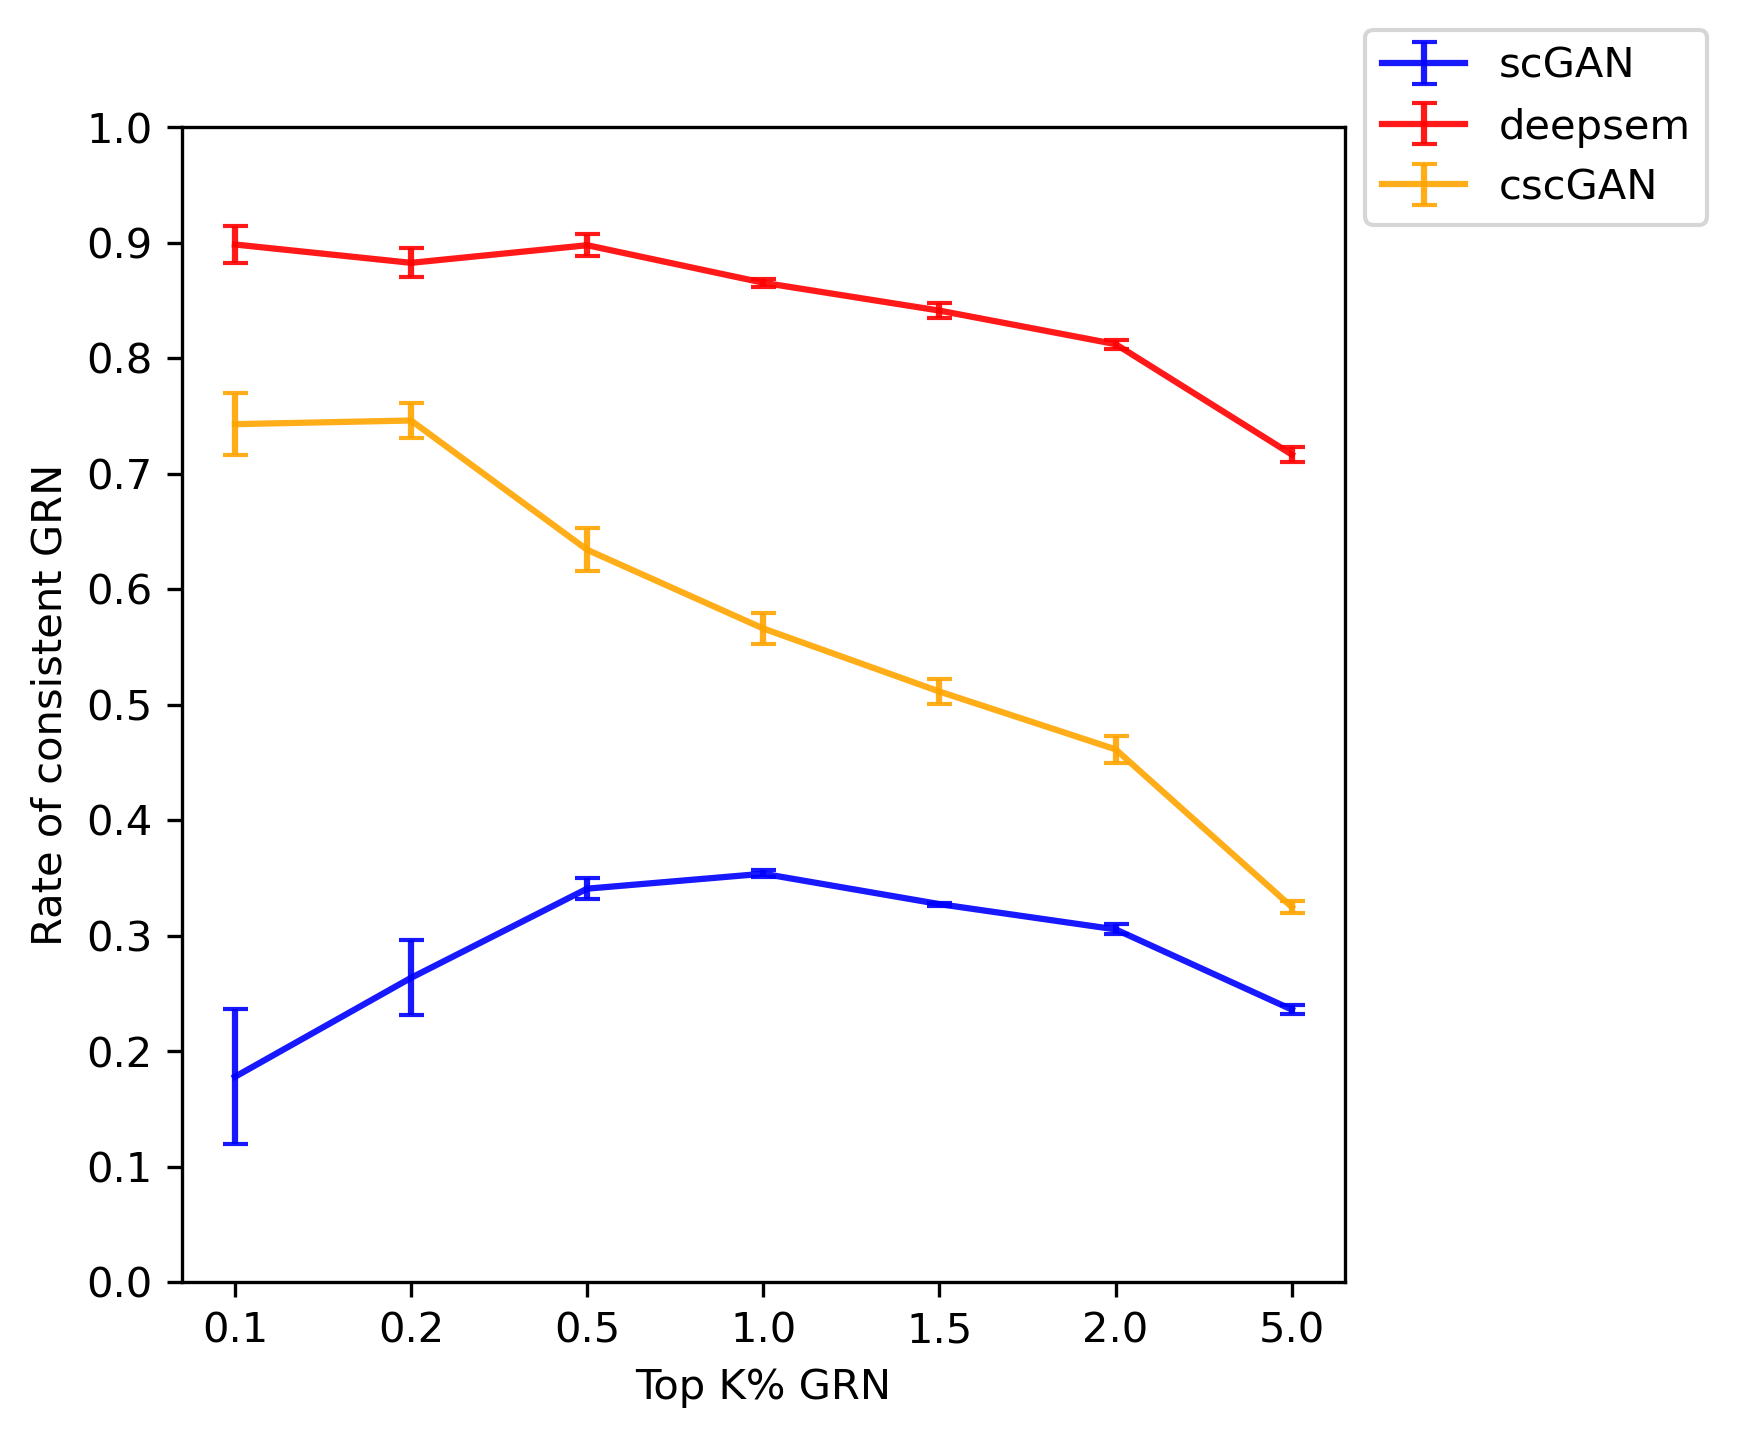

In [196]:
res = pd.DataFrame(res)
all_result.append(res)
x = list(range(len(lb)))
styles=['fivethirtyeight',
 'dark_background',
 'bmh',
 'classic',
 'seaborn-dark',
 'grayscale',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-colorblind',
 'seaborn-white',
 'seaborn-dark-palette',
 'ggplot',
 'tableau-colorblind10',
 '_classic_test',
 'seaborn-darkgrid',
 'seaborn-notebook',
 'Solarize_Light2',
 'seaborn-paper',
 'seaborn-whitegrid',
 'seaborn-pastel',
 'seaborn-talk',
 'seaborn-bright',
 'seaborn',
 'seaborn-ticks',
 'seaborn-poster',
 'fast']
palette = ['blue','red','orange',]
plt.figure(figsize=(5, 5), dpi=300)
# palette = pyplot.get_cmap('Set1')
plt.style.use('default')
for i,method in enumerate(set(res['Method'])):
    print(method)
    tmp = res[res['Method']==method].sort_values('Top')
    tmp = pd.DataFrame(tmp.groupby('Top').apply(lambda x: 1.96*x['Number of Same GRN'].std()/(5**0.5))).reset_index().merge(tmp)
    tmp2 = tmp.groupby('Top').mean().reset_index()
    plt.errorbar(tmp2['Top'], tmp2['Number of Same GRN'],yerr=tmp2[0], color=palette[i], linewidth=1.5, alpha=0.9,label=method,capsize=3)

plt.ylabel('Rate of consistent GRN')
plt.xlabel('Top K% GRN')
plt.xticks(x,np.array(lb)*100)
miny = max(int((res['Number of Same GRN'].min()-0.1)*10) /10.,0)
maxy = min(1,int((res['Number of Same GRN'].max()+0.1)*10) /10.)
plt.legend(bbox_to_anchor=(1,1),loc='center left')
plt.yticks(np.arange(miny, maxy+0.1,0.1))

